In [1]:
%matplotlib inline

import os
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def get_stats_from_file(filename):
    with open(filename, 'r') as file:
        header = file.readline().split()
        stats_lists = [[cat] for cat in header]
        for line in file:
            for i,stat in enumerate(line.strip().split()):
                if i is 0: stat = datetime.fromtimestamp(float(stat)).strftime('%H:%M:%S.%f')[:-4]

                elif i is 1: stat = float(stat)
                else: stat = int(stat)
                stats_lists[i].append(stat)
                
        file_stats = {list[0]: list[1:] for list in stats_lists}
        return file_stats

In [3]:
stats = {}
for filename in os.listdir('argusout'):
    stats[filename.strip('.out')] = get_stats_from_file('argusout/' + filename)

In [4]:
def hide_nth_xtick(ax, n):
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

In [31]:
def plot_stats(stats, node):
    params = {
       'axes.labelsize': 14,
       'font.size': 15,
       'legend.fontsize': 11,
       'legend.handlelength': 2,
       'xtick.labelsize': 12,
       'ytick.labelsize': 12,
       'text.usetex': False,
       'figure.figsize': [20, 20]
    }
    plt.rcParams.update(params)
    
    fig = plt.figure()
    cur_node = stats.get(node)
    
    cpu = fig.add_subplot(511)
    cpu.set_xlabel('Time')
    cpu.set_ylabel('CPU usage')
    cpu.set_title('Percentage of CPU usage')
    
    mem = fig.add_subplot(512)
    mem.set_xlabel('Time')
    mem.set_ylabel('Memory (in bytes)')
    mem.set_title('Active Memory usage')
    
    failed = fig.add_subplot(513)
    failed.set_xlabel('Time')
    failed.set_ylabel('Puzzles')
    failed.set_title('Number of Puzzles Failed')
    
    received = fig.add_subplot(514)
    received.set_xlabel('Time')
    received.set_ylabel('Puzzles')
    received.set_title('Number of Puzzles Received')
    
    sent = fig.add_subplot(515)
    sent.set_xlabel('Time')
    sent.set_ylabel('Puzzles')
    sent.set_title('Number of Puzzles Sent')
    
    cpu.plot(cur_node['Timestamp'], cur_node['cpu_percent'],'bo-',label='CPU percent')
    mem.plot(cur_node['Timestamp'], cur_node['active_memory'],'bo-',label='Active memory')
    failed.plot(cur_node['Timestamp'], cur_node['ChallengeFailed'],'bo-',label='Puzzles Failed')
    received.plot(cur_node['Timestamp'], cur_node['ChallengeRecvd'],'bo-',label='Puzzles Received')
    sent.plot(cur_node['Timestamp'], cur_node['ChallengeSent'],'bo-',label='Puzzles Sent')
    
    for plot in [cpu, mem, failed, received, sent]: hide_nth_xtick(plot, 6)
    
    fig.tight_layout(pad=1, h_pad=1)
    plt.show()

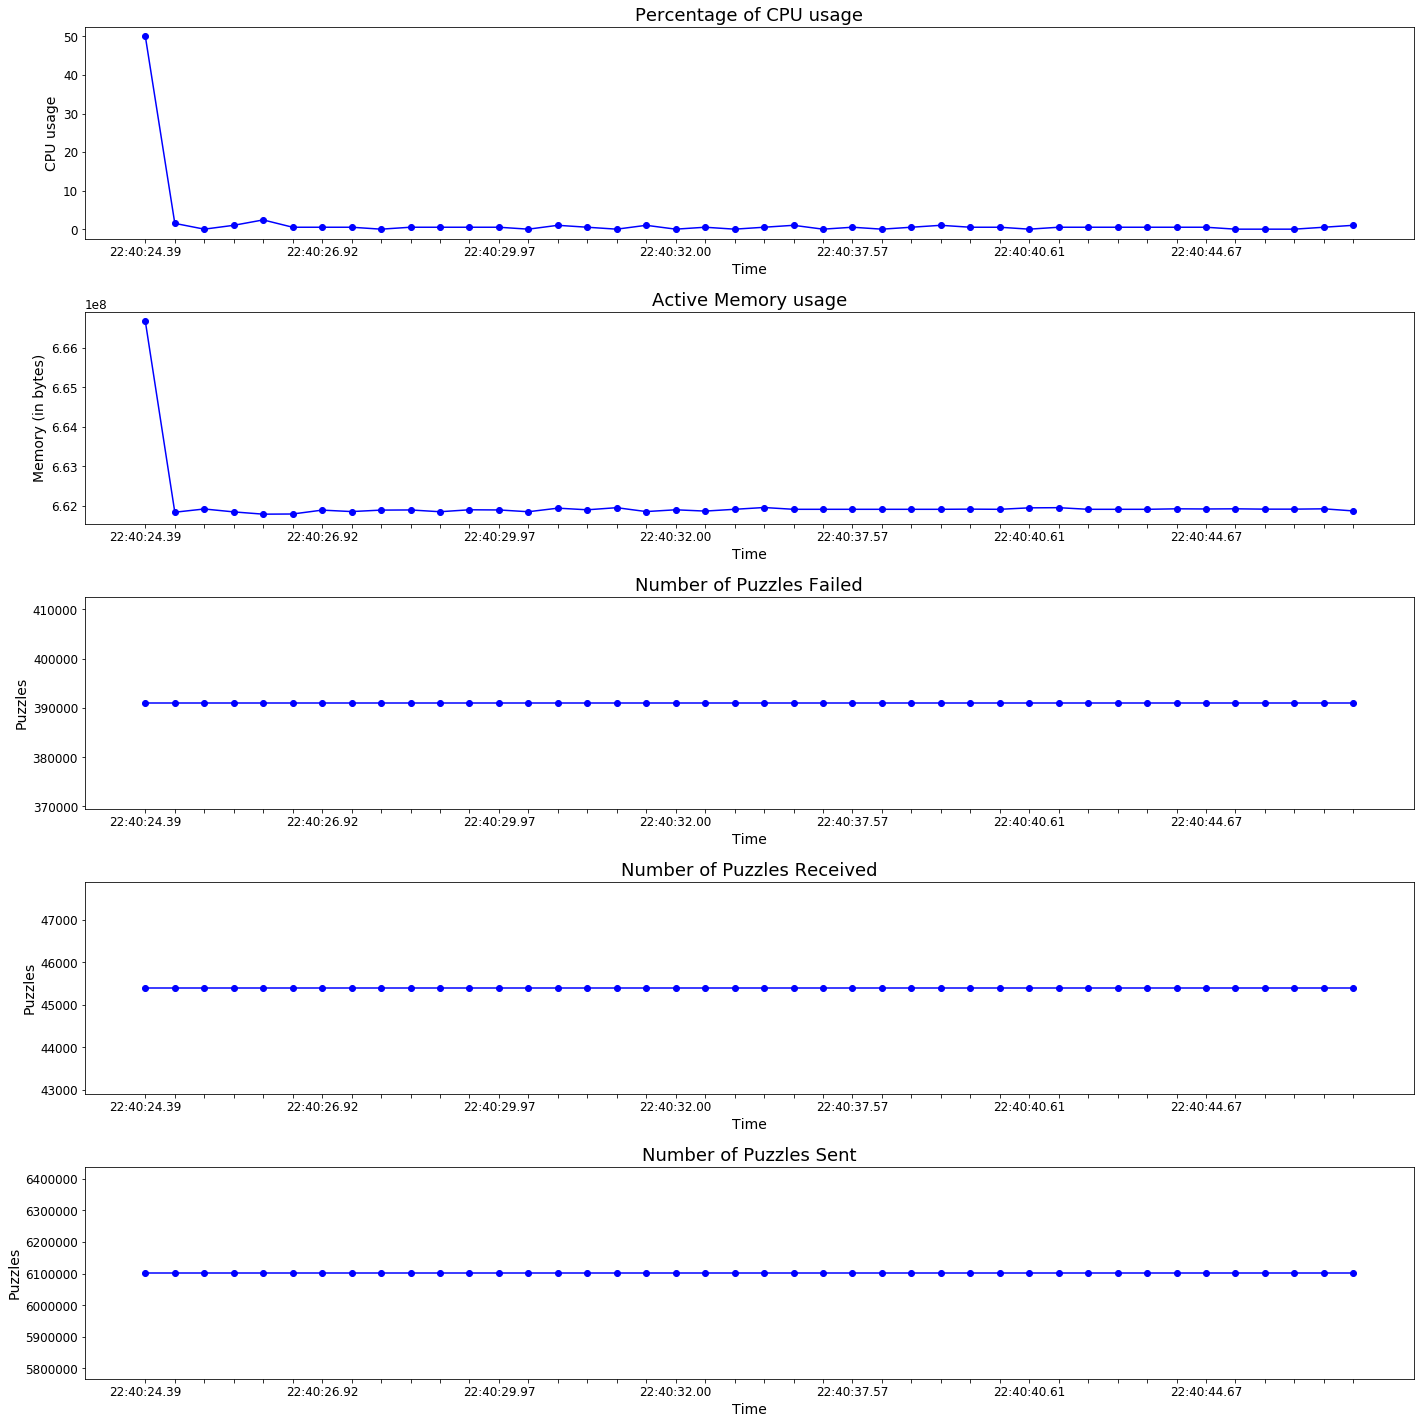

In [32]:
plot_stats(stats, 'attacknode1')